In [81]:
from IPython.core.debugger import set_trace

%load_ext nb_black


import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [82]:
csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AAPL/AAPL_WITH_TWINT_FINBERT_SA.csv"

<IPython.core.display.Javascript object>

In [83]:
df = pd.read_csv(csv_path)
df.sort_values(by=["date"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

date_time = pd.to_datetime(df.pop('date'))

df = df[["5. adjusted close"]].copy()

<IPython.core.display.Javascript object>

In [84]:
split_time = int(len(df) * .9)

train_df = df[:split_time]
test_df = df[split_time:]

print(len(train_df))
print(len(test_df))

df = test_df[["5. adjusted close"]].copy()

2757
307


<IPython.core.display.Javascript object>

In [85]:
df.describe()

,5. adjusted close
count,307.000000
mean,144.064500
std,17.110906
min,115.673069
25%,129.784479
50%,142.899557
75%,153.472276
max,181.778019


<IPython.core.display.Javascript object>

In [86]:
df.head()

,5. adjusted close
2757,126.934789
2758,126.865306
2759,127.748728
2760,125.718843
2761,127.282202


<IPython.core.display.Javascript object>

### Check if the time series is stationary

In [87]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["5. adjusted close"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.1478551879928298
p-value: 0.6956156636511684


<IPython.core.display.Javascript object>

#### Autocorrelation Function (ACF)

In [88]:
from statsmodels.graphics.tsaplots import plot_acf

<IPython.core.display.Javascript object>

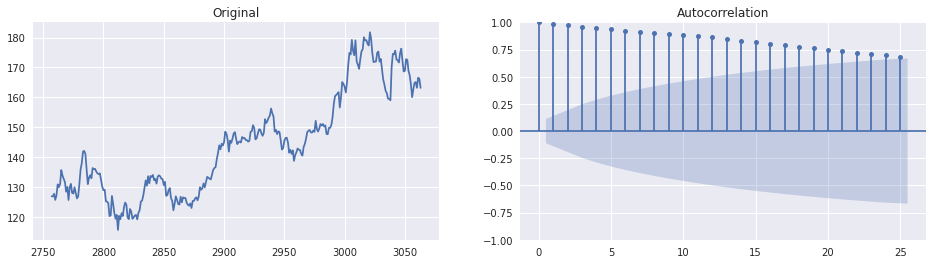

<IPython.core.display.Javascript object>

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(df["5. adjusted close"])
ax1.set_title("Original")
plot_acf(df["5. adjusted close"], ax=ax2);

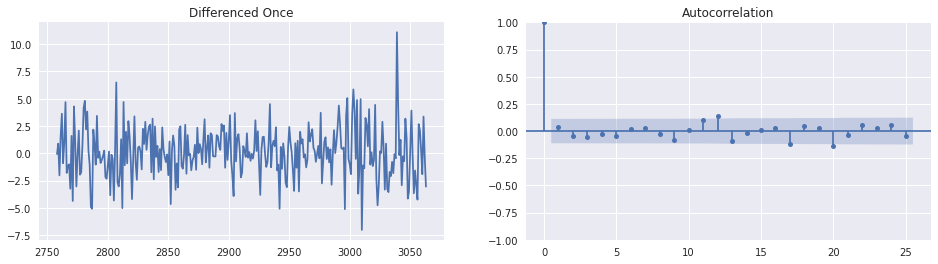

<IPython.core.display.Javascript object>

In [90]:
diff = df["5. adjusted close"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_acf(diff, ax=ax2);

In [91]:
# pip install pmdarima
from pmdarima.arima.utils import ndiffs

<IPython.core.display.Javascript object>

In [92]:
ndiffs(df["5. adjusted close"])

1

<IPython.core.display.Javascript object>

__p__

p is the order of the Auto Regressive (AR) term.  It refers to the number of lags to be used as predictors.

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags.

In [93]:
from statsmodels.graphics.tsaplots import plot_pacf

<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


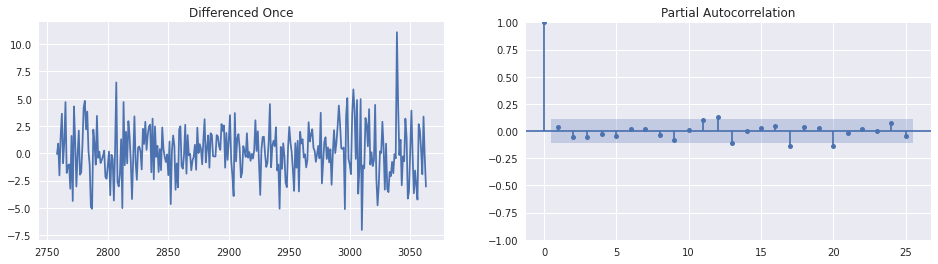

<IPython.core.display.Javascript object>

In [94]:
diff = df["5. adjusted close"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_pacf(diff, ax=ax2);

__q__

q is the order of the Moving Average (MA) term.  It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.



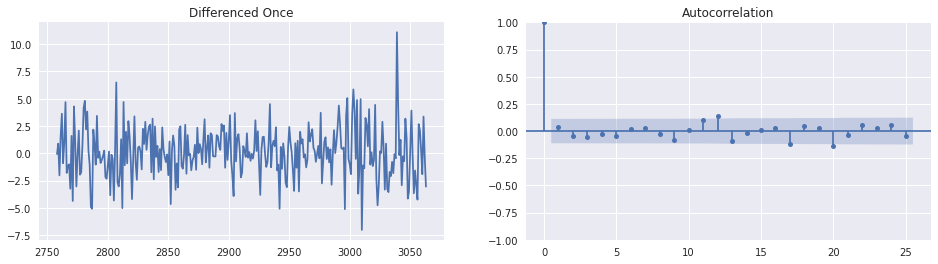

<IPython.core.display.Javascript object>

In [95]:
diff = df["5. adjusted close"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_acf(diff, ax=ax2);

#### Fitting the ARIMA Model

In [96]:
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df["5. adjusted close"], order=(17,1,20))
result = model.fit()


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<IPython.core.display.Javascript object>

In [97]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      5. adjusted close   No. Observations:                  307
Model:               ARIMA(17, 1, 20)   Log Likelihood                -672.411
Date:                Sat, 09 Jul 2022   AIC                           1420.822
Time:                        04:54:57   BIC                           1562.318
Sample:                             0   HQIC                          1477.411
                                - 307                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3042      0.293      1.040      0.299      -0.269       0.878
ar.L2         -0.1631      0.236     -0.692      0.489      -0.625       0.299
ar.L3          0.0590      0.272      0.217      0.828      -0.474       0.591
ar.L4         -0.3125      0.210     -1.486      0.137      -0.724       0.100
ar.L5          0.1245      0.215      0.579      0.562      -0.297       0.546
ar.L6         -0.0159      0.180     -0.089      0.929      -0.368       0.336
ar.L7          0.2254      0.168      1.340      0.180      -0.104       0.555
ar.L8          0.1403      0.133      1.054      0.292      -0.121       0.401
ar.L9          0.0474      0.130      0.365      0.715      -0.207       0.302
ar.L10         0.2841      0.129      2.204      0.028       0.031       0.537
ar.L11         0.1846      0.175      1.056      0.291      -0.158       0.527
ar.L12         0.2752      0.177      1.557      0.120      -0.071       0.622
ar.L13        -0.4925      0.220     -2.239      0.025      -0.924      -0.061
ar.L14         0.3125      0.196      1.591      0.112      -0.073       0.698
ar.L15        -0.1106      0.263     -0.421      0.674      -0.626       0.405
ar.L16         0.2757      0.222      1.240      0.215      -0.160       0.711
ar.L17        -0.4854      0.228     -2.125      0.034      -0.933      -0.038
ma.L1         -0.2506      0.298     -0.840      0.401      -0.835       0.334
ma.L2          0.1531      0.236      0.647      0.517      -0.310       0.617
ma.L3         -0.0983      0.280     -0.351      0.726      -0.648       0.451
ma.L4          0.2910      0.219      1.327      0.184      -0.139       0.721
ma.L5         -0.1427      0.224     -0.637      0.524      -0.582       0.296
ma.L6          0.0555      0.195      0.285      0.776      -0.326       0.437
ma.L7         -0.2618      0.190     -1.377      0.168      -0.634       0.111
ma.L8         -0.1612      0.149     -1.078      0.281      -0.454       0.132
ma.L9         -0.1141      0.152     -0.751      0.452      -0.412       0.184
ma.L10        -0.2832      0.171     -1.658      0.097      -0.618       0.052
ma.L11        -0.1151      0.202     -0.569      0.569      -0.512       0.281
ma.L12        -0.1881      0.193     -0.973      0.330      -0.567       0.191
ma.L13         0.4467      0.220      2.035      0.042       0.016       0.877
ma.L14        -0.2760      0.205     -1.349      0.177      -0.677       0.125
ma.L15         0.1748      0.261      0.669      0.503      -0.337       0.687
ma.L16        -0.2300      0.220     -1.044      0.296      -0.662       0.202
ma.L17         0.3851      0.218      1.768      0.077      -0.042       0.812
ma.L18         0.0905      0.087      1.044      0.296      -0.079       0.260
ma.L19         0.0077      0.096      0.080      0.936      -0.181       0.196
ma.L20        -0.2221      0.095     -2.337      0.019      -0.408      -0.036
sigma2         4.6211      0.404     11.439      0.000       3.829       5.413
==

<IPython.core.display.Javascript object>

In [98]:
# Actual vs. Fitted

# result.plot_diagnostics()
len(result.forecasts[0])

307

<IPython.core.display.Javascript object>

In [99]:
df["preds"] = result.forecasts[0]

<IPython.core.display.Javascript object>

In [100]:
df.head()

,5. adjusted close,preds
2757,126.934789,0.000000
2758,126.865306,126.934821
2759,127.748728,126.862269
2760,125.718843,127.798784
2761,127.282202,125.527714


<IPython.core.display.Javascript object>

In [101]:
result.forecasts[0][-306:]

array([126.93482067, 126.86226938, 127.79878392, 125.52771417,
       127.55370718, 131.01647276, 129.34394541, 131.17070944,
       135.95737863, 132.87365639, 132.54551063, 132.16843878,
       128.13461479, 129.8815469 , 125.55454381, 131.19608371,
       131.11796747, 127.2478524 , 128.79608554, 130.99427166,
       127.01130788, 125.16465546, 128.05905236, 131.16122685,
       134.38195364, 138.49605916, 142.84184988, 140.37122978,
       140.33082431, 136.14376002, 131.8014384 , 132.5132953 ,
       132.75319802, 134.95032688, 136.54338154, 134.79982815,
       137.47048685, 136.3634334 , 134.54003256, 133.66174747,
       134.15181022, 132.68233689, 129.25964571, 127.07179218,
       129.38531243, 126.49935443, 125.13383023, 124.59226975,
       121.29929247, 122.30195293, 125.97916719, 122.91617493,
       120.75275533, 118.2569932 , 120.50799637, 115.92067914,
       121.84500153, 120.56626703, 120.07344751, 119.7362166 ,
       123.96455912, 125.80783749, 121.10968971, 118.78

<IPython.core.display.Javascript object>

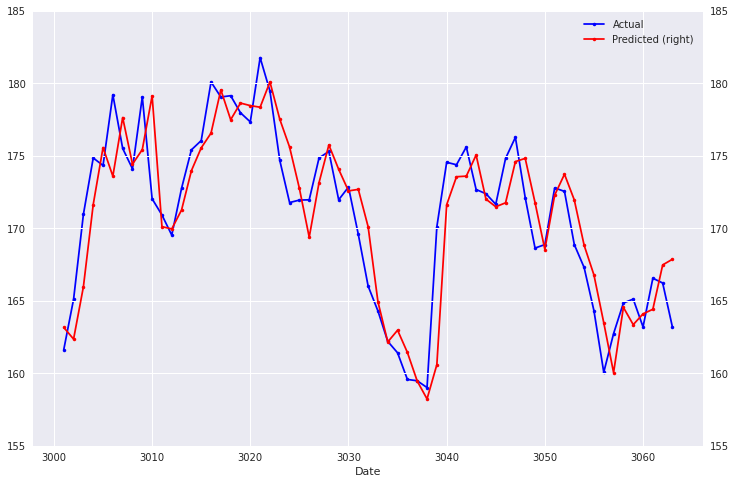

<IPython.core.display.Javascript object>

In [102]:
plt.figure(figsize=(12,8))

ax1 = df["5. adjusted close"][-63:].plot(color='blue', grid=True, secondary_y=False, label='Actual', marker='.')
ax2 = df["preds"][-63:].plot(color='red', grid=True, secondary_y=True, label='Predicted', marker='.')

a, b = 155, 185

ax1.set_ylim(a,b)
ax2.set_ylim(a,b)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_xlabel("Date")
plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [103]:
true = df["5. adjusted close"][-244:]
predicted = df["preds"][-244:]

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))


print(mae(true, predicted))

1.5698431265892814


<IPython.core.display.Javascript object>

In [104]:
df.tail()

,5. adjusted close,preds
3059,165.12,163.357182
3060,163.20,164.100419
3061,166.56,164.418701
3062,166.23,167.478174
3063,163.17,167.871599


<IPython.core.display.Javascript object>

In [105]:
df = df[-244:].copy()

true = df["5. adjusted close"][-244:]
predicted = df["preds"][-244:]

<IPython.core.display.Javascript object>

In [106]:
from sklearn.metrics import mean_absolute_error

<IPython.core.display.Javascript object>

In [107]:
test_mae = mean_absolute_error(true.to_numpy(), predicted)
f'Test MAE: {test_mae:.4f}'

'Test MAE: 1.5698'

<IPython.core.display.Javascript object>

In [108]:
df.tail(10)

,5. adjusted close,preds
3054,167.30,168.836257
3055,164.32,166.784189
3056,160.07,163.489727
3057,162.74,160.048619
3058,164.85,164.549246
3059,165.12,163.357182
3060,163.20,164.100419
3061,166.56,164.418701
3062,166.23,167.478174
3063,163.17,167.871599


<IPython.core.display.Javascript object>

In [109]:
df["actual_percentage_change"] = df['5. adjusted close'].pct_change()
df["actual_increase"] = df["actual_percentage_change"].apply(lambda x: 1 if x > 0 else 0)

<IPython.core.display.Javascript object>

In [110]:
df["predicted_percentage_change"] = df['preds'].pct_change()
df["predicted_increase"] = df["predicted_percentage_change"].apply(lambda x: 1 if x > 0 else 0)

<IPython.core.display.Javascript object>

In [111]:
df.head()

,5. adjusted close,preds,actual_percentage_change,actual_increase,predicted_percentage_change,predicted_increase
2820,119.818452,121.109690,NaN,0,NaN,0
2821,119.281640,118.780304,-0.004480,0,-0.019234,0
2822,122.661568,121.216294,0.028336,1,0.020508,1
2823,121.816586,123.189049,-0.006889,0,0.016275,1
2824,119.381049,120.889696,-0.019993,0,-0.018665,0


<IPython.core.display.Javascript object>

In [113]:
df = df.drop(2820)

<IPython.core.display.Javascript object>

In [114]:
df[df["actual_increase"] > 0].shape

(128, 6)

<IPython.core.display.Javascript object>

In [115]:
df[df["actual_increase"] <= 0].shape

(115, 6)

<IPython.core.display.Javascript object>

In [116]:
df.tail()

,5. adjusted close,preds,actual_percentage_change,actual_increase,predicted_percentage_change,predicted_increase
3059,165.12,163.357182,0.001638,1,-0.007244,0
3060,163.20,164.100419,-0.011628,0,0.004550,1
3061,166.56,164.418701,0.020588,1,0.001940,1
3062,166.23,167.478174,-0.001981,0,0.018608,1
3063,163.17,167.871599,-0.018408,0,0.002349,1


<IPython.core.display.Javascript object>

#### Postive Increase Prediction %

In [117]:
df[(df["actual_increase"]==1) & (df["predicted_increase"]==1)].shape[0] / df[(df["actual_increase"]==1)].shape[0]

0.5703125

<IPython.core.display.Javascript object>

### Negative Increase Prediction %

In [118]:
df[(df["actual_increase"]==0) & (df["predicted_increase"]==0)].shape[0] / df[(df["actual_increase"]==0)].shape[0]

0.5304347826086957

<IPython.core.display.Javascript object>

#### Overall Prediction Accuracy %

In [119]:
df[(df["actual_increase"] == df["predicted_increase"])].shape[0] / (df.shape[0])

0.551440329218107

<IPython.core.display.Javascript object>

#### Actual Distribution of Increase (1) vs. Decrease (0)

In [120]:
df["actual_increase"].value_counts(normalize=True)

1    0.526749
0    0.473251
Name: actual_increase, dtype: float64

<IPython.core.display.Javascript object>